In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
from sklearn.model_selection import train_test_split, learning_curve
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
import warnings

# Ignorer tous les warnings
warnings.filterwarnings('ignore')

In [3]:
def prepare_features(df, window=5, min_games=3):
    df = df.sort_values("Date").reset_index(drop=True)
    records = []
    team_stats = {}

    for i, row in df.iterrows():
        home, away = row["HomeTeam"], row["AwayTeam"]

        def get_form(team):
            history = team_stats.get(team, [])
            if len(history) < min_games:
                return None
            recent = history[-window:]
            m1st = [h[0] for h in recent]
            m2nd = [h[1] for h in recent]
            enc1st = [h[2] for h in recent]
            enc2nd = [h[3] for h in recent]
            pts = [h[4] for h in recent]
            return {
                "goals_1st": np.mean(m1st),
                "goals_2nd": np.mean(m2nd),
                "conceded_1st": np.mean(enc1st),
                "conceded_2nd": np.mean(enc2nd),
                "pts": np.mean(pts)
            }

        hf = get_form(home)
        af = get_form(away)

        if hf and af:
            record = {
                "total_avg_goals_home": hf["goals_1st"] + hf["goals_2nd"] + hf["conceded_1st"] + hf["conceded_2nd"],
                "total_avg_goals_away": af["goals_1st"] + af["goals_2nd"] + af["conceded_1st"] + af["conceded_2nd"],
                "goal_diff_home": (hf["goals_1st"] + hf["goals_2nd"]) - (hf["conceded_1st"] + hf["conceded_2nd"]),
                "goal_diff_away": (af["goals_1st"] + af["goals_2nd"]) - (af["conceded_1st"] + af["conceded_2nd"]),
                "pts_recent_home": hf["pts"],
                "pts_recent_away": af["pts"],
                "odds_diff": row.get("B365H", np.nan) - row.get("B365A", np.nan),
                "odds_draw_gap": row.get("B365D", np.nan) - np.mean([row.get("B365H", np.nan), row.get("B365A", np.nan)]),
                "odds_mean": np.mean([row.get("B365H", np.nan), row.get("B365D", np.nan), row.get("B365A", np.nan)]),
                "target": row["target"]
            }
            records.append(record)

        result_home = 3 if row["FTHG"] > row["FTAG"] else 1 if row["FTHG"] == row["FTAG"] else 0
        result_away = 3 - result_home if result_home in [0, 3] else 1
        team_stats.setdefault(home, []).append((row["HTHG"], row["FTHG"] - row["HTHG"],
                                                row["HTAG"], row["FTAG"] - row["HTAG"], result_home))
        team_stats.setdefault(away, []).append((row["HTAG"], row["FTAG"] - row["HTAG"],
                                                row["HTHG"], row["FTHG"] - row["HTHG"], result_away))

    return pd.DataFrame(records)

In [4]:
raw = pd.read_csv('../../data/fl/data_2000_2025_11_Mai.csv')
raw

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,GoalsAvg_Away,Year,Month,Weekday,OddsRatio_HA,OddsDiff_HD,OddsDiff_AD,OddsGap_MinDelta,Form_Diff,IsDraw
0,0,2003-02-01,Rennes,Lens,1.0,1.0,1,1.0,1.0,0,...,0.0,2003,2,5,0.783972,-0.75,-0.13,0.75,0,1
1,1,2003-02-01,Monaco,Sedan,3.0,0.0,0,2.0,0.0,1,...,0.0,2003,2,5,0.301818,-1.21,2.63,3.84,0,0
2,2,2003-02-01,Lyon,Nantes,0.0,0.0,1,0.0,0.0,0,...,0.0,2003,2,5,0.368889,-1.59,1.25,2.84,0,1
3,3,2003-02-01,Le Havre,Troyes,1.0,0.0,0,0.0,0.0,0,...,0.0,2003,2,5,0.415704,-1.20,1.33,2.53,0,0
4,4,2003-02-01,Auxerre,Sochaux,2.0,0.0,0,1.0,0.0,1,...,0.0,2003,2,5,0.344000,-1.15,2.13,3.28,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8478,8478,2024-11-30,Brest,Strasbourg,3.0,1.0,0,2.0,0.0,1,...,1.5,2024,11,5,0.666667,-1.20,-0.10,1.20,0,0
8479,8479,2025-01-31,Montpellier,Lens,0.0,2.0,2,0.0,1.0,2,...,2.6,2025,1,4,2.366120,0.63,-1.87,2.50,0,0
8480,8480,2024-08-31,Toulouse,Marseille,1.0,3.0,2,0.0,2.0,2,...,1.4,2024,8,5,2.000000,0.00,-1.90,1.90,0,0
8481,8481,2024-08-31,Montpellier,Nantes,1.0,3.0,2,1.0,2.0,2,...,2.3,2024,8,5,0.703125,-1.15,-0.20,1.15,0,0


In [5]:
df=raw.copy()

In [6]:
cols=['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR',
      'HTHG','HTAG','HTR','B365H', 'B365A','B365D']
df=df[cols]
df=df.sort_values('Date')
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
22,2002-08-02,Guingamp,Lyon,3.0,3.0,1,1.0,2.0,2,3.200,2.100,3.000
48,2002-08-03,Paris SG,Auxerre,1.0,0.0,0,0.0,0.0,0,1.833,4.000,3.000
47,2002-08-03,Bastia,Lens,1.0,1.0,1,0.0,0.0,0,2.500,2.625,2.875
46,2002-08-03,Lille,Bordeaux,0.0,3.0,2,0.0,1.0,2,2.100,3.200,3.000
45,2002-08-03,Marseille,Nantes,0.0,2.0,2,0.0,0.0,0,2.250,2.875,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...
8293,2025-05-10,Reims,St Etienne,0.0,2.0,2,0.0,2.0,2,2.100,3.200,3.700
8292,2025-05-10,Montpellier,Paris SG,1.0,4.0,2,0.0,1.0,2,9.000,1.250,7.000
8289,2025-05-10,Brest,Lille,2.0,0.0,0,1.0,0.0,1,4.500,1.750,3.800
8291,2025-05-10,Monaco,Lyon,2.0,0.0,0,0.0,0.0,0,1.830,3.700,4.200


In [41]:
df['B365D'].fillna(round(df['B365D'].mean(),3), inplace=True)
df['B365A'].fillna(round(df['B365A'].mean(),3), inplace=True)
df['B365H'].fillna(round(df['B365H'].mean(),3), inplace=True)

In [42]:
df['HTHG'].fillna(df['HTHG'].mean(), inplace=True)
df['HTAG'].fillna(df['HTAG'].mean(), inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8483 entries, 22 to 8290
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8483 non-null   object 
 1   HomeTeam  8483 non-null   object 
 2   AwayTeam  8483 non-null   object 
 3   FTHG      8483 non-null   float64
 4   FTAG      8483 non-null   float64
 5   FTR       8483 non-null   int64  
 6   HTHG      8483 non-null   float64
 7   HTAG      8483 non-null   float64
 8   HTR       8483 non-null   int64  
 9   B365H     8483 non-null   float64
 10  B365A     8483 non-null   float64
 11  B365D     8483 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 861.6+ KB


In [8]:
df['Date']=pd.to_datetime(df['Date'])
df=df.sort_values(by='Date')

In [9]:
df=df.drop_duplicates()
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
22,2002-08-02,Guingamp,Lyon,3.0,3.0,1,1.0,2.0,2,3.200,2.100,3.000
48,2002-08-03,Paris SG,Auxerre,1.0,0.0,0,0.0,0.0,0,1.833,4.000,3.000
47,2002-08-03,Bastia,Lens,1.0,1.0,1,0.0,0.0,0,2.500,2.625,2.875
46,2002-08-03,Lille,Bordeaux,0.0,3.0,2,0.0,1.0,2,2.100,3.200,3.000
45,2002-08-03,Marseille,Nantes,0.0,2.0,2,0.0,0.0,0,2.250,2.875,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...
8295,2025-05-10,Angers,Strasbourg,2.0,1.0,0,1.0,1.0,0,4.200,1.800,3.750
8296,2025-05-10,Rennes,Nice,2.0,0.0,0,1.0,0.0,1,3.600,1.950,3.800
8297,2025-05-10,Auxerre,Nantes,1.0,1.0,1,1.0,0.0,1,2.800,2.450,3.400
8294,2025-05-10,Toulouse,Lens,1.0,1.0,1,0.0,0.0,0,2.250,3.100,3.500


In [10]:
# Générer la variable cible : 1 si plus de buts en 2e mi-temps, sinon 0
df["target"] = ((df["HTHG"] + df["HTAG"]) <= 
                ((df["FTHG"] - df["HTHG"]) + (df["FTAG"] - df["HTAG"]))).astype(int)
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D,target
22,2002-08-02,Guingamp,Lyon,3.0,3.0,1,1.0,2.0,2,3.200,2.100,3.000,1
48,2002-08-03,Paris SG,Auxerre,1.0,0.0,0,0.0,0.0,0,1.833,4.000,3.000,1
47,2002-08-03,Bastia,Lens,1.0,1.0,1,0.0,0.0,0,2.500,2.625,2.875,1
46,2002-08-03,Lille,Bordeaux,0.0,3.0,2,0.0,1.0,2,2.100,3.200,3.000,1
45,2002-08-03,Marseille,Nantes,0.0,2.0,2,0.0,0.0,0,2.250,2.875,3.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8295,2025-05-10,Angers,Strasbourg,2.0,1.0,0,1.0,1.0,0,4.200,1.800,3.750,0
8296,2025-05-10,Rennes,Nice,2.0,0.0,0,1.0,0.0,1,3.600,1.950,3.800,1
8297,2025-05-10,Auxerre,Nantes,1.0,1.0,1,1.0,0.0,1,2.800,2.450,3.400,1
8294,2025-05-10,Toulouse,Lens,1.0,1.0,1,0.0,0.0,0,2.250,3.100,3.500,1


In [11]:
df['Date']=pd.to_datetime(df['Date'])
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D,target
22,2002-08-02,Guingamp,Lyon,3.0,3.0,1,1.0,2.0,2,3.200,2.100,3.000,1
48,2002-08-03,Paris SG,Auxerre,1.0,0.0,0,0.0,0.0,0,1.833,4.000,3.000,1
47,2002-08-03,Bastia,Lens,1.0,1.0,1,0.0,0.0,0,2.500,2.625,2.875,1
46,2002-08-03,Lille,Bordeaux,0.0,3.0,2,0.0,1.0,2,2.100,3.200,3.000,1
45,2002-08-03,Marseille,Nantes,0.0,2.0,2,0.0,0.0,0,2.250,2.875,3.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8295,2025-05-10,Angers,Strasbourg,2.0,1.0,0,1.0,1.0,0,4.200,1.800,3.750,0
8296,2025-05-10,Rennes,Nice,2.0,0.0,0,1.0,0.0,1,3.600,1.950,3.800,1
8297,2025-05-10,Auxerre,Nantes,1.0,1.0,1,1.0,0.0,1,2.800,2.450,3.400,1
8294,2025-05-10,Toulouse,Lens,1.0,1.0,1,0.0,0.0,0,2.250,3.100,3.500,1


<Axes: xlabel='target'>

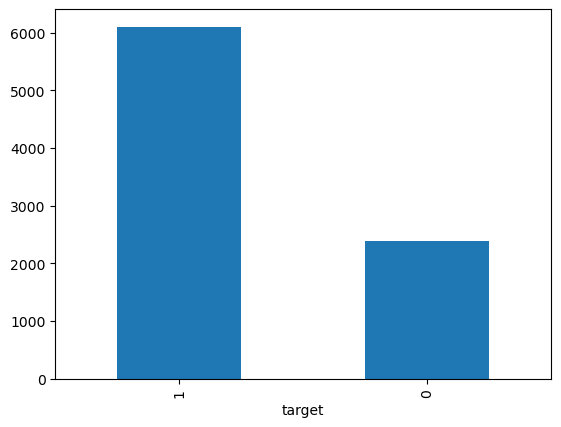

In [26]:
df["target"].value_counts().plot.bar()

In [13]:
# Générer le dataset
df_model = prepare_features(df)
df_model

,total_avg_goals_home,total_avg_goals_away,goal_diff_home,goal_diff_away,pts_recent_home,pts_recent_away,odds_diff,odds_draw_gap,odds_mean,target
0,2.000000,2.333333,-2.000000,-1.666667,0.333333,0.333333,-2.20,0.200,2.966667,1
1,5.000000,1.333333,1.666667,0.000000,1.666667,1.333333,-6.10,-0.850,4.166667,0
2,1.333333,2.666667,1.333333,-1.333333,2.333333,0.666667,-6.10,-0.850,4.166667,1
3,2.000000,2.666667,0.666667,0.666667,1.000000,1.666667,-2.20,0.200,2.966667,0
4,1.333333,1.666667,-1.333333,-0.333333,0.333333,1.333333,-0.30,0.450,2.700000,1
...,...,...,...,...,...,...,...,...,...,...
8387,1.000000,3.600000,0.200000,-0.800000,1.400000,0.800000,-1.10,1.050,3.000000,0
8388,3.800000,2.800000,-0.600000,0.800000,1.400000,2.000000,2.75,0.675,3.350000,1
8389,2.200000,2.600000,-1.800000,-0.200000,0.200000,1.400000,7.75,1.875,5.750000,1
8390,2.400000,3.600000,0.800000,0.800000,1.600000,1.800000,-1.87,1.435,3.243333,1


In [65]:
from imblearn.over_sampling import SMOTE

In [66]:
#df_model_smote=df_model.copy()
#Séparation des features et de la cible
x_all = df_model.drop(columns=["target"]).dropna()
y_all = df_model["target"].loc[X.index]

In [43]:
smote=SMOTE(random_state=120)
X, y=smote.fit_resample(x_all, y_all)

In [14]:
#Séparation des features et de la cible
X = df_model.drop(columns=["target"]).dropna()
y = df_model["target"].loc[X.index]

In [15]:
x_train, x_test, y_train, y_test=train_test_split(X,y, test_size=0.3, random_state=110)

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5874, 9)
(5874,)
(2518, 9)
(2518,)


In [17]:
# Entraînement du modèle XGBoost
model = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.05,
        scale_pos_weight=1,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

In [27]:
model.fit(x_train, y_train)
y_pred1=model.predict(x_test)
print("[XGBClassifier] occuracy:", accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

[XGBClassifier] occuracy: 0.7132644956314536
              precision    recall  f1-score   support

           0       0.26      0.01      0.02       711
           1       0.72      0.99      0.83      1807

    accuracy                           0.71      2518
   macro avg       0.49      0.50      0.42      2518
weighted avg       0.59      0.71      0.60      2518



In [19]:
pred_entr=model.predict(x_train)
score_entr=accuracy_score(y_train, pred_entr)
score=accuracy_score(y_test, y_pred1)
print('Model '+ str(model))
print(" ")
print('Le meilleur score globale  sur les donnéés d'' entrainement :', round(score_entr,3))
print('-'*80)
print('Le meilleur score globale  sur les donnéés test :', round(score,3))
print('-'*80)

Model Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                     

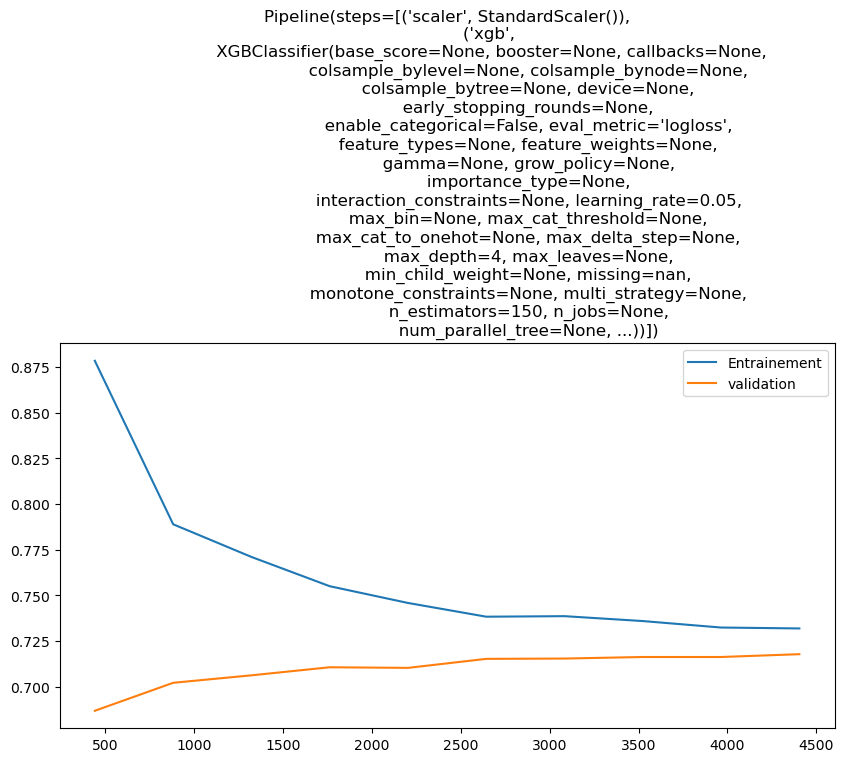

In [20]:
def affichage():
    N, train_set, val_score=learning_curve(model, x_train, y_train, cv=4, scoring='accuracy',
                                         train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(10,5))
    plt.plot(N, train_set.mean(axis=1), label='Entrainement')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.title(model)
    plt.legend()
affichage()

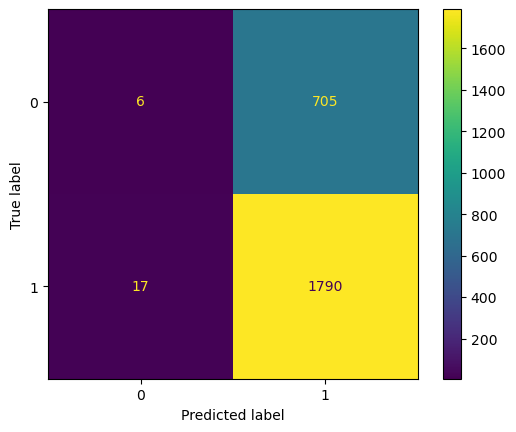

In [28]:
cm = confusion_matrix(y_test, y_pred1, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

In [22]:
model2=LogisticRegression(C=10, max_iter=1000,random_state=110, class_weight='balanced')
model2.fit(x_train, y_train)
y_pred2=model2.predict(x_test)
#print("[LogReg] accuracy :",accuracy_score(y_test,y_pred2))
print("[LogReg] occuracy:", accuracy_score(y_test, y_pred2))
print(classification_report(y_test,y_pred2))

[LogReg] occuracy: 0.5158856235107228
              precision    recall  f1-score   support

           0       0.28      0.46      0.35       711
           1       0.72      0.54      0.62      1807

    accuracy                           0.52      2518
   macro avg       0.50      0.50      0.48      2518
weighted avg       0.59      0.52      0.54      2518



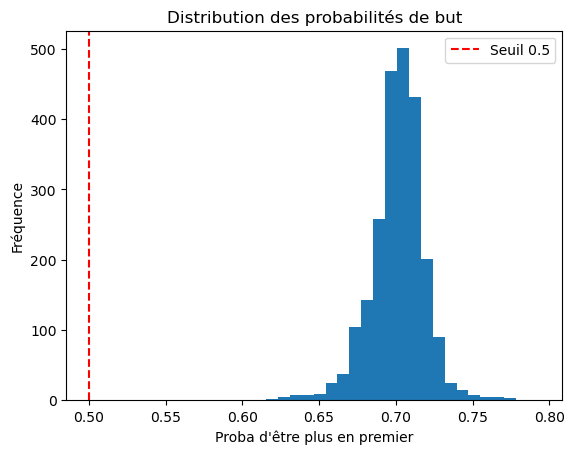

In [36]:
proba_draws = model2.predict_proba(x_test)[:,1]  # Proba que le match soit nul
plt.hist(proba_draws, bins=30)
plt.axvline(0.5, color='red', linestyle='--', label='Seuil 0.5')
plt.title("Distribution des probabilités de but")
plt.xlabel("Proba d'être plus en premier")
plt.ylabel("Fréquence")
plt.legend()
plt.show()

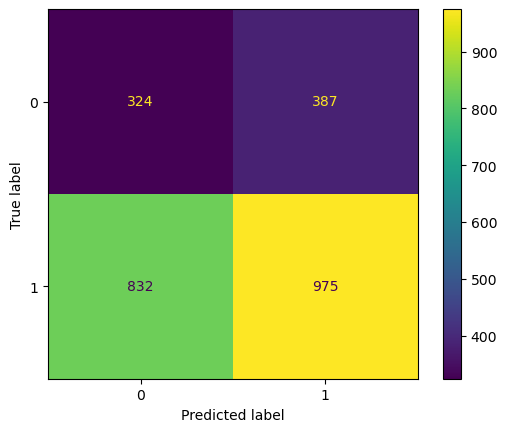

In [25]:
cm = confusion_matrix(y_test, y_pred2, labels=model2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model2.classes_)
disp.plot()
plt.show()

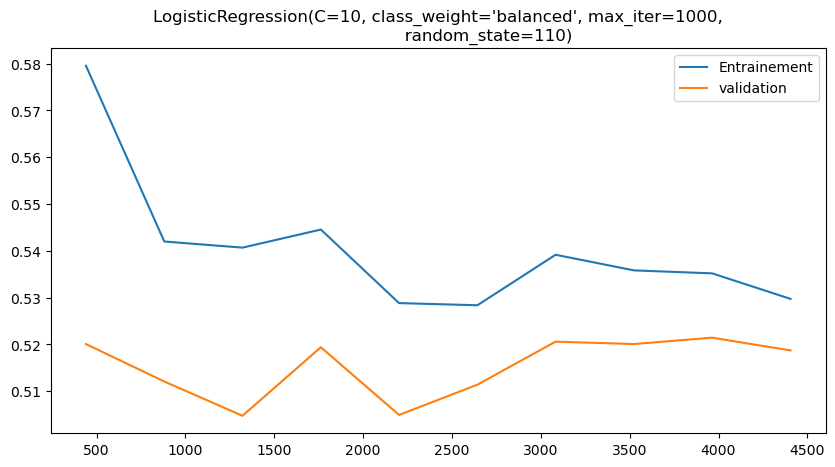

In [24]:
def affichage():
    N, train_set, val_score=learning_curve(model2, x_train, y_train, cv=4, scoring='accuracy',
                                         train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(10,5))
    plt.plot(N, train_set.mean(axis=1), label='Entrainement')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.title(model2)
    plt.legend()
affichage()

In [30]:
### dataset avec bet
hi=pd.read_csv('../../data/fl/fl_26_04_2025_cote.csv')
hi=hi[['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR',
      'HTHG','HTAG','HTR','B365H', 'B365A', 'B365D']]
hi

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
0,2024-08-16,Le Havre,Paris SG,1,4,A,0,1,A,7.00,1.42,4.75
1,2024-08-17,Brest,Marseille,1,5,A,1,3,A,3.00,2.40,3.30
2,2024-08-17,Reims,Lille,0,2,A,0,1,A,3.30,2.20,3.40
3,2024-08-17,Monaco,St Etienne,1,0,H,1,0,H,1.48,6.25,4.50
4,2024-08-18,Auxerre,Nice,2,1,H,1,1,D,3.10,2.35,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...
301,2025-05-17,Nantes,Montpellier,3,0,H,2,0,H,1.53,5.50,4.50
302,2025-05-17,Nice,Brest,6,0,H,3,0,H,1.48,6.50,4.50
303,2025-05-17,Paris SG,Auxerre,3,1,H,0,1,A,1.20,13.00,7.00
304,2025-05-17,St Etienne,Toulouse,2,3,A,1,2,A,1.95,3.25,4.20


In [31]:
hi['Date']=pd.to_datetime(hi['Date'])

In [32]:
hi[hi['Date']>'2025-05-10']

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
297,2025-05-17,Lens,Monaco,4,0,H,1,0,H,3.90,1.83,4.10
298,2025-05-17,Lille,Reims,2,1,H,1,0,H,1.38,8.50,4.75
299,2025-05-17,Lyon,Angers,2,0,H,0,0,D,1.29,9.00,6.00
300,2025-05-17,Marseille,Rennes,4,2,H,3,1,H,1.75,4.20,3.90
301,2025-05-17,Nantes,Montpellier,3,0,H,2,0,H,1.53,5.50,4.50
302,2025-05-17,Nice,Brest,6,0,H,3,0,H,1.48,6.50,4.50
303,2025-05-17,Paris SG,Auxerre,3,1,H,0,1,A,1.20,13.00,7.00
304,2025-05-17,St Etienne,Toulouse,2,3,A,1,2,A,1.95,3.25,4.20
305,2025-05-17,Strasbourg,Le Havre,2,3,A,1,1,D,1.57,5.00,4.75


In [33]:
pd.set_option('display.max_columns', None)

In [38]:
fl=pd.read_csv('../../data/fl/fl_2025_full.csv')
fl

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HTGS,ATGS,HTGC,ATGC,HHGS,AHGS,HHGC,AHGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
0,0,2024-08-16,Le Havre,Paris Saint Germain,1,4,0,1,A,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
1,1,2024-08-17,Stade Brestois 29,Marseille,1,5,1,0,A,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
2,2,2024-08-17,Reims,Lille,0,2,0,0,A,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
3,3,2024-08-17,Monaco,Saint Etienne,1,0,1,0,H,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
4,4,2024-08-18,Auxerre,Nice,2,1,1,1,H,0,0,0,0,0,0,0,0,0,0,M,M,M,M,M,M,M,M,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,301,2025-05-17,Nice,Stade Brestois 29,6,0,3,3,H,60,52,41,53,33,29,25,34,57,50,L,W,W,W,W,L,W,L,D,D
302,302,2025-05-17,Paris Saint Germain,Auxerre,3,1,0,3,H,89,47,34,48,34,29,27,26,81,42,W,D,L,L,L,W,D,L,W,L
303,303,2025-05-17,Strasbourg,Le Havre,2,3,1,1,A,54,37,41,69,27,26,28,17,57,31,L,L,W,W,W,D,D,L,D,L
304,304,2025-05-17,Lens,Monaco,4,0,1,3,H,38,63,39,37,15,24,17,35,49,61,D,W,W,W,L,D,W,D,L,W


In [39]:
fl.drop('Unnamed: 0', axis=1, inplace=True)
fl[fl['Date']<='2025-05-10'].to_csv('../../data/fl/fl.csv')

In [42]:
fl[(fl['Date']>'2025-05-10')].iloc[0:3,:].to_csv('../../data/fl/saison_encours.csv')
#lg[(lg['Date']>'2025-05-15')]

In [44]:
fl[(fl['Date']>'2025-05-15')].iloc[3:,:]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,FTR,HTGS,ATGS,HTGC,ATGC,HHGS,AHGS,HHGC,AHGC,HTP,ATP,HM1,AM1,HM2,AM2,HM3,AM3,HM4,AM4,HM5,AM5
300,2025-05-17,Nantes,Montpellier,3,0,2,1,H,36,23,52,76,23,27,27,25,33,16,D,L,L,L,D,D,D,L,L,L
301,2025-05-17,Nice,Stade Brestois 29,6,0,3,3,H,60,52,41,53,33,29,25,34,57,50,L,W,W,W,W,L,W,L,D,D
302,2025-05-17,Paris Saint Germain,Auxerre,3,1,0,3,H,89,47,34,48,34,29,27,26,81,42,W,D,L,L,L,W,D,L,W,L
303,2025-05-17,Strasbourg,Le Havre,2,3,1,1,A,54,37,41,69,27,26,28,17,57,31,L,L,W,W,W,D,D,L,D,L
304,2025-05-17,Lens,Monaco,4,0,1,3,H,38,63,39,37,15,24,17,35,49,61,D,W,W,W,L,D,W,D,L,W
305,2025-05-17,Saint Etienne,Toulouse,2,3,1,1,A,37,41,74,41,30,21,36,18,30,39,W,D,L,W,L,D,W,L,D,L


In [143]:
pd.set_option('display.max_columns', None)

In [45]:
#hi[hi['Date']<='2025-05-05'].to_csv('../../data/sa1/saison_preced.csv')
#pl[pl['Date']<='2025-05-05']

saison_preced=hi[hi['Date']<='2025-05-10']
saison_preced

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
0,2024-08-16,Le Havre,Paris SG,1,4,A,0,1,A,7.00,1.42,4.75
1,2024-08-17,Brest,Marseille,1,5,A,1,3,A,3.00,2.40,3.30
2,2024-08-17,Reims,Lille,0,2,A,0,1,A,3.30,2.20,3.40
3,2024-08-17,Monaco,St Etienne,1,0,H,1,0,H,1.48,6.25,4.50
4,2024-08-18,Auxerre,Nice,2,1,H,1,1,D,3.10,2.35,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...
292,2025-05-10,Monaco,Lyon,2,0,H,0,0,D,1.83,3.70,4.20
293,2025-05-10,Montpellier,Paris SG,1,4,A,0,1,A,9.00,1.25,7.00
294,2025-05-10,Reims,St Etienne,0,2,A,0,2,A,2.10,3.20,3.70
295,2025-05-10,Rennes,Nice,2,0,H,1,0,H,3.60,1.95,3.80


In [46]:
saison_encours=hi[(hi['Date']>'2025-05-10')].iloc[0:3,:]
saison_encours

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
297,2025-05-17,Lens,Monaco,4,0,H,1,0,H,3.90,1.83,4.10
298,2025-05-17,Lille,Reims,2,1,H,1,0,H,1.38,8.50,4.75
299,2025-05-17,Lyon,Angers,2,0,H,0,0,D,1.29,9.00,6.00


In [47]:
hi[(hi['Date']>'2025-05-10')].iloc[3:,:]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
300,2025-05-17,Marseille,Rennes,4,2,H,3,1,H,1.75,4.20,3.90
301,2025-05-17,Nantes,Montpellier,3,0,H,2,0,H,1.53,5.50,4.50
302,2025-05-17,Nice,Brest,6,0,H,3,0,H,1.48,6.50,4.50
303,2025-05-17,Paris SG,Auxerre,3,1,H,0,1,A,1.20,13.00,7.00
304,2025-05-17,St Etienne,Toulouse,2,3,A,1,2,A,1.95,3.25,4.20
305,2025-05-17,Strasbourg,Le Havre,2,3,A,1,1,D,1.57,5.00,4.75


In [48]:
test_df=hi[(hi['Date']>'2025-05-10')].iloc[3:,:].copy()
test_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D
300,2025-05-17,Marseille,Rennes,4,2,H,3,1,H,1.75,4.20,3.90
301,2025-05-17,Nantes,Montpellier,3,0,H,2,0,H,1.53,5.50,4.50
302,2025-05-17,Nice,Brest,6,0,H,3,0,H,1.48,6.50,4.50
303,2025-05-17,Paris SG,Auxerre,3,1,H,0,1,A,1.20,13.00,7.00
304,2025-05-17,St Etienne,Toulouse,2,3,A,1,2,A,1.95,3.25,4.20
305,2025-05-17,Strasbourg,Le Havre,2,3,A,1,1,D,1.57,5.00,4.75


In [49]:
test_df["target"] = ((test_df["HTHG"] + test_df["HTAG"]) <= 
                ((test_df["FTHG"] - test_df["HTHG"]) + (test_df["FTAG"] - test_df["HTAG"]))).astype(int)
test_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,B365H,B365A,B365D,target
300,2025-05-17,Marseille,Rennes,4,2,H,3,1,H,1.75,4.20,3.90,0
301,2025-05-17,Nantes,Montpellier,3,0,H,2,0,H,1.53,5.50,4.50,0
302,2025-05-17,Nice,Brest,6,0,H,3,0,H,1.48,6.50,4.50,1
303,2025-05-17,Paris SG,Auxerre,3,1,H,0,1,A,1.20,13.00,7.00,1
304,2025-05-17,St Etienne,Toulouse,2,3,A,1,2,A,1.95,3.25,4.20,0
305,2025-05-17,Strasbourg,Le Havre,2,3,A,1,1,D,1.57,5.00,4.75,1


In [50]:
def entree_utilisateur(home_team, away_team, b365h,b365a,b365d, season_current, season_previous):
    # 🔧 Chargement des arguments
    # ---------------------
    home_team=str(home_team)
    away_team=str(away_team)
    b365h=float(b365h)
    b365a=float(b365a)
    b365d=float(b365d)
    
    #df_curr = pd.read_csv(args.season_current, parse_dates=["Date"])
    df_curr = season_current.copy()
    df_curr['Date']=pd.to_datetime(df_curr['Date'])
    df_curr=df_curr.sort_values(by='Date')
    df_prev = season_previous.copy()
    df_prev['Date']=pd.to_datetime(df_prev['Date'])
    df_prev=df_prev.sort_values(by='Date')
    
    df_prev["goals_1s"] = df_prev["HTHG"] + df_prev["HTAG"]
    df_prev["goals_2n"] = (df_prev["FTHG"] + df_prev["FTAG"]) - df_prev["goals_1s"]

    df_prev["conceded_1s"] = df_prev["goals_1s"]  # pour les moyennes globales, c’est la même chose
    df_prev["conceded_2n"] = df_prev["goals_2n"]

    # Calcul des points (pts) par match selon le résultat
    df_prev["pts"] = df_prev["FTR"].map({"H": 3, "D": 1, "A": 0})
    
    # 📊 Moyennes globales
    # ---------------------
    league_avg = {
        "goals_1st": round(df_prev["goals_1s"].mean(), 2),
        "goals_2nd": round(df_prev["goals_2n"].mean(), 2),
        "conceded_1st": round(df_prev["conceded_1s"].mean(), 2),
        "conceded_2nd": round(df_prev["conceded_2n"].mean(), 2),
        "pts": round(df_prev["pts"].mean(), 2)
    }
    
    def compute_form(team, df, window=5):
        
        df_team = df[(df["HomeTeam"] == team) | (df["AwayTeam"] == team)].sort_values("Date", ascending=True)
        if len(df_team) == 0:
            return None
        form = []
        for _, row in df_team.iterrows():
            is_home = row["HomeTeam"] == team
            hthg, fthg = row["HTHG"], row["FTHG"]
            htag, ftag = row["HTAG"], row["FTAG"]

            g1 = hthg if is_home else htag
            g2 = (fthg - hthg) if is_home else (ftag - htag)
            c1 = htag if is_home else hthg
            c2 = (ftag - htag) if is_home else (fthg - hthg)

            if (fthg == ftag): pts = 1
            elif (is_home and fthg > ftag) or (not is_home and ftag > fthg): pts = 3
            else: pts = 0

            form.append((g1, g2, c1, c2, pts))

        if len(form) < 3:
            return None
        last = form[-window:]
        return {
            "goals_1st": np.mean([x[0] for x in last]),
            "goals_2nd": np.mean([x[1] for x in last]),
            "conceded_1st": np.mean([x[2] for x in last]),
            "conceded_2nd": np.mean([x[3] for x in last]),
            "pts": np.mean([x[4] for x in last])
            }
    def get_final_form(team):
        
        # Priorité : saison en cours
        f1 = compute_form(team, df_curr)
        if f1: return f1
        # Sinon, saison précédente
        f2 = compute_form(team, df_prev)
        if f2: return f2
        # Sinon, valeurs moyennes
        return league_avg
    home_stats = get_final_form(home_team)
    away_stats = get_final_form(away_team)
    
    input_features = {
    "total_avg_goals_home": home_stats["goals_1st"] + home_stats["goals_2nd"] + home_stats["conceded_1st"] + home_stats["conceded_2nd"],
    "total_avg_goals_away": away_stats["goals_1st"] + away_stats["goals_2nd"] + away_stats["conceded_1st"] + away_stats["conceded_2nd"],
    "goal_diff_home": (home_stats["goals_1st"] + home_stats["goals_2nd"]) - (home_stats["conceded_1st"] + home_stats["conceded_2nd"]),
    "goal_diff_away": (away_stats["goals_1st"] + away_stats["goals_2nd"]) - (away_stats["conceded_1st"] + away_stats["conceded_2nd"]),
    "pts_recent_home": home_stats["pts"],
    "pts_recent_away": away_stats["pts"],
    "odds_diff": b365h - b365a,
    "odds_draw_gap": b365d - np.mean([b365h,b365a]),
    "odds_mean": np.mean([b365h, b365d, b365a])}
    
    return pd.DataFrame([input_features])

In [54]:
results = []
for _, row in test_df.iterrows():
    X_inputs=entree_utilisateur(home_team=row['HomeTeam'], 
                                away_team=row['AwayTeam'], 
                                b365h=row['B365H'],
                                b365a=row['B365A'],
                                b365d=row['B365D'], 
                                season_current=saison_preced, 
                                season_previous=saison_encours)
    
    pred = model.predict(X_inputs)[0]
    resul= {'home':row['HomeTeam'],
            'away':row['AwayTeam'],
            'val_reel':row['target'],
           'val_pred':pred}
    results.append(resul)

In [55]:
res=pd.DataFrame.from_dict(results)
res

,home,away,val_reel,val_pred
0,Marseille,Rennes,0,1
1,Nantes,Montpellier,0,1
2,Nice,Brest,1,1
3,Paris SG,Auxerre,1,1
4,St Etienne,Toulouse,0,1
5,Strasbourg,Le Havre,1,1


In [220]:
import joblib

In [57]:
joblib.dump(model, 'xgboost_nbre_but_marque_fl.joblib')

['xgboost_nbre_but_marque_fl.joblib']

In [56]:
nbre_total=res.shape[0]
nbre_win=res[res['val_reel']==res['val_pred']].shape[0]
nbre_fail=res[res['val_reel']!=res['val_pred']].shape[0]
print("succès:", (nbre_win/nbre_total)*100)
print("echec:", (nbre_fail/nbre_total)*100)

succès: 50.0
echec: 50.0


In [99]:
hi[hi['Date']>'2025-05-11'].iloc[0:3,:].to_csv('../../data/bl1/saison_encours.csv')

In [179]:
season_current=pd.read_csv('../../data/bl1/saison_encours.csv')
season_previous=pd.read_csv('../../data/bl1/saison_preced.csv')
home_team='Heidenheim'
away_team='PLI'
b365h=2.30
b365a=2.75
b365d=3.80

In [ ]:
hi.sort_values(by='Date')

In [102]:
import argparse
from datetime import datetime

In [193]:
def entree_utilisateur(home_team, away_team, b365h,b365a,b365d, season_current, season_previous):
    # 🔧 Chargement des arguments
    # ---------------------
    home_team=str(home_team)
    away_team=str(away_team)
    b365h=float(b365h)
    b365a=float(b365a)
    b365d=float(b365d)
    
    #df_curr = pd.read_csv(args.season_current, parse_dates=["Date"])
    df_curr = season_current.copy()
    df_curr['Date']=pd.to_datetime(df_curr['Date'])
    df_curr=df_curr.sort_values(by='Date')
    df_prev = season_previous.copy()
    df_prev['Date']=pd.to_datetime(df_prev['Date'])
    df_prev=df_prev.sort_values(by='Date')
    
    # 📊 Moyennes globales
    # ---------------------
    league_avg = {
        "goals_1st": 0.6,
        "goals_2nd": 0.9,
        "conceded_1st": 0.6,
        "conceded_2nd": 0.9,
        "pts": 1.2
    }
    
    def compute_form(team, df, window=5):
        
        df_team = df[(df["HomeTeam"] == team) | (df["AwayTeam"] == team)].sort_values("Date", ascending=True)
        if len(df_team) == 0:
            return None
        form = []
        for _, row in df_team.iterrows():
            is_home = row["HomeTeam"] == team
            hthg, fthg = row["HTHG"], row["FTHG"]
            htag, ftag = row["HTAG"], row["FTAG"]

            g1 = hthg if is_home else htag
            g2 = (fthg - hthg) if is_home else (ftag - htag)
            c1 = htag if is_home else hthg
            c2 = (ftag - htag) if is_home else (fthg - hthg)

            if (fthg == ftag): pts = 1
            elif (is_home and fthg > ftag) or (not is_home and ftag > fthg): pts = 3
            else: pts = 0

            form.append((g1, g2, c1, c2, pts))

        if len(form) < 3:
            return None
        last = form[-window:]
        return {
            "goals_1st": np.mean([x[0] for x in last]),
            "goals_2nd": np.mean([x[1] for x in last]),
            "conceded_1st": np.mean([x[2] for x in last]),
            "conceded_2nd": np.mean([x[3] for x in last]),
            "pts": np.mean([x[4] for x in last])
            }
    def get_final_form(team):
        
        # Priorité : saison en cours
        f1 = compute_form(team, df_curr)
        if f1: return f1
        # Sinon, saison précédente
        f2 = compute_form(team, df_prev)
        if f2: return f2
        # Sinon, valeurs moyennes
        return league_avg
    home_stats = get_final_form(home_team)
    away_stats = get_final_form(away_team)
    
    input_features = {
    "total_avg_goals_home": home_stats["goals_1st"] + home_stats["goals_2nd"] + home_stats["conceded_1st"] + home_stats["conceded_2nd"],
    "total_avg_goals_away": away_stats["goals_1st"] + away_stats["goals_2nd"] + away_stats["conceded_1st"] + away_stats["conceded_2nd"],
    "goal_diff_home": (home_stats["goals_1st"] + home_stats["goals_2nd"]) - (home_stats["conceded_1st"] + home_stats["conceded_2nd"]),
    "goal_diff_away": (away_stats["goals_1st"] + away_stats["goals_2nd"]) - (away_stats["conceded_1st"] + away_stats["conceded_2nd"]),
    "pts_recent_home": home_stats["pts"],
    "pts_recent_away": away_stats["pts"],
    "odds_diff": b365h - b365a,
    "odds_draw_gap": b365d - np.mean([b365h,b365a]),
    "odds_mean": np.mean([b365h, b365d, b365a])}
    
    return pd.DataFrame([input_features])

In [194]:
X_inputs=entree_utilisateur(home_team, away_team, b365h,b365a,b365d, season_current, season_previous)

In [195]:
X_inputs

,total_avg_goals_home,total_avg_goals_away,goal_diff_home,goal_diff_away,pts_recent_home,pts_recent_away,odds_diff,odds_draw_gap,odds_mean
0,2.2,3.0,-0.6,0.0,1.4,1.2,-0.45,1.275,2.95


In [196]:
pred = model.predict(X_inputs)[0]

# ---------------------
# ✅ Résultat
# ---------------------
print("✅ Prédiction :", "Plus de buts en 2ᵉ mi-temps" if pred == 1 else "Plus de buts en 1ʳᵉ mi-temps")

✅ Prédiction : Plus de buts en 2ᵉ mi-temps


In [223]:
pred

1

In [118]:
leags=pd.read_csv('../../data/results_2024_2025_with_halves.csv')
leags

,league,date,home_team,away_team,score_home,score_away,home_goals_1st_half,home_goals_2nd_half,away_goals_1st_half,away_goals_2nd_half
0,France_Ligue1,2024-08-16T18:45:00+00:00,Le Havre,Paris Saint Germain,1,4,0,1,1,3
1,France_Ligue1,2024-08-17T15:00:00+00:00,Stade Brestois 29,Marseille,1,5,1,0,3,2
2,France_Ligue1,2024-08-17T17:00:00+00:00,Reims,Lille,0,2,0,0,1,1
3,France_Ligue1,2024-08-17T19:00:00+00:00,Monaco,Saint Etienne,1,0,1,0,0,0
4,France_Ligue1,2024-08-18T13:00:00+00:00,Auxerre,Nice,2,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
7502,Greece_SuperLeague,2025-05-18T15:00:00+00:00,Lamia,Panetolikos,1,3,1,0,1,2
7503,Greece_SuperLeague,2025-05-18T17:00:00+00:00,Volos NFC,Kallithea,0,2,0,0,1,1
7504,Greece_SuperLeague,2025-05-22T15:00:00+00:00,Panetolikos,Panserraikos,1,0,1,0,0,0
7505,Greece_SuperLeague,2025-05-22T15:00:00+00:00,Levadiakos,Volos NFC,3,2,1,2,1,1
